# Tutorial 5: PO efficiencies and metrics.
In this tutorial, we will simulate a simple Cassegrain reflector telescope. We demonstrate how `PyPO` can be used to calculate some common figures of merit, such as efficiencies and far-field parameters.

In [16]:
%matplotlib widget
# Uncomment for interactive plots when running the notebook!
# Requires installation of the ipympl package

import numpy as np

from PyPO.System import System
from PyPO.Enums import FieldComponents, CurrentComponents, Units, Scales


In [2]:

s = System()

2026-02-27 16:19:12 - WARNING - System override set to True. 


In [49]:

# Set the wavelength to work at
lam = 2*Units.MM


In [50]:
# Calculate the grid sizes required

In [51]:

parabola = {
            "name"      : "primary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "vertex"    : np.zeros(3)*Units.MM,
            "focus_1"   : np.array([0, 0, 3.5e3])*Units.MM,
            "lims_u"    : np.array([300, 5e3])*Units.MM,
            "lims_v"    : np.array([0, 360])*Units.DEG,
            "gridsize"  : np.array([1801, 800])
            }

s.addParabola(parabola)

hyperbola = {
            "name"      : "secondary",
            "pmode"     : "focus",
            "gmode"     : "uv",
            "flip"      : True,
            "focus_1"   : np.array([0, 0, 3.5e3])*Units.MM,
            "focus_2"   : np.array([0, 0, -1e3])*Units.MM,
            "ecc"       : 1.1,
            "lims_u"    : np.array([0, 300])*Units.MM,
            "lims_v"    : np.array([0, 360]),
            "gridsize"  : np.array([int(2*300/lam), int(300*4*np.pi/lam)])
            }

s.addHyperbola(hyperbola)

focus = {
            "name"      : "focus",
            "gmode"     : "uv",
            "lims_u"    : np.array([0, 100])*Units.MM,
            "lims_v"    : np.array([0, 360])*Units.DEG,
            "gridsize"  : np.array([101, 100])
            }

s.addPlane(focus)

farfield = {
            "name"      : "farfield",
            "gmode"     : "AoE",
            "lims_Az"    : np.array([-.2, .2])*Units.DEG,
            "lims_El"    : np.array([-.2, .2])*Units.DEG,
            "gridsize"  : np.array([101, 101])
            }

s.addPlane(farfield)

GPODict = {                                                                                                                                                                     
            "name"      : "source",                                                                                                                                  
            "lam"       : lam,                                                                                                      
            "w0x"       : 5*Units.MM,                                                                                             
            "w0y"       : 5*Units.MM,                                                                                             
            "n"         : 1,                                                                                                                             
            "E0"        : 1,                                                                                                                                  
            "dxyz"      : 0,                                                                                                 
            "pol"       : np.array([1, 0, 0])                                                                                                          
}

s.createGaussian(GPODict, "focus")
s.translateGrids("focus", np.array([0, 0, -1e3])*Units.MM)

2026-02-27 16:40:08 - INFO - Added paraboloid primary to system. 
2026-02-27 16:40:08 - INFO - Added hyperboloid secondary to system. 
2026-02-27 16:40:08 - INFO - Added plane focus to system. 
2026-02-27 16:40:08 - INFO - Added plane farfield to system. 
2026-02-27 16:40:08 - INFO - Translated element focus by ('0.000e+00', '0.000e+00', '-1.000e+03') millimeters. 


We start by defining the Cassegrain reflectors. we also place a Gaussian beam in the lower focus of the Cassegrain. We define the Gaussian such that the secondary has an edge taper of roughly -11 dB. 

Now we are going to calculate all currents on the reflectors and the far-field. WARNING: the following code might take alot of time, especially if you are not running CUDA.

In [52]:
device = "GPU"

source_to_sec = {
        "t_name"    : "secondary",
        "s_current" : "source",
        "mode"      : "JMEH",
        "name_JM"   : "JM_sec",
        "name_EH"   : "EH_sec",
        "device"    : device
        }

s.runPO(source_to_sec)

sec_to_pri = {
        "t_name"    : "primary",
        "s_current" : "JM_sec",
        "mode"      : "JMEH",
        "name_JM"   : "JM_pri",
        "name_EH"   : "EH_pri",
        "device"    : device
        }

s.runPO(sec_to_pri)


2026-02-27 16:40:12 - WORK - *** Starting PO propagation *** 
2026-02-27 16:40:12 - WORK - Propagating source on focus to secondary, propagation mode: JMEH. 
2026-02-27 16:40:12 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-27 16:40:12 - WORK - ... Calculating ... 
2026-02-27 16:40:13 - WORK - *** Finished: 0.751 seconds *** 
2026-02-27 16:40:13 - WORK - *** Starting PO propagation *** 
2026-02-27 16:40:13 - WORK - Propagating JM_sec on secondary to primary, propagation mode: JMEH. 
2026-02-27 16:40:13 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-27 16:40:13 - WORK - ... Calculating ... 
2026-02-27 16:40:37 - WORK - *** Finished: 23.664 seconds *** 


In [53]:
np.array([int(2*300/lam), int(300*4*np.pi/lam)])

array([ 300, 1884])

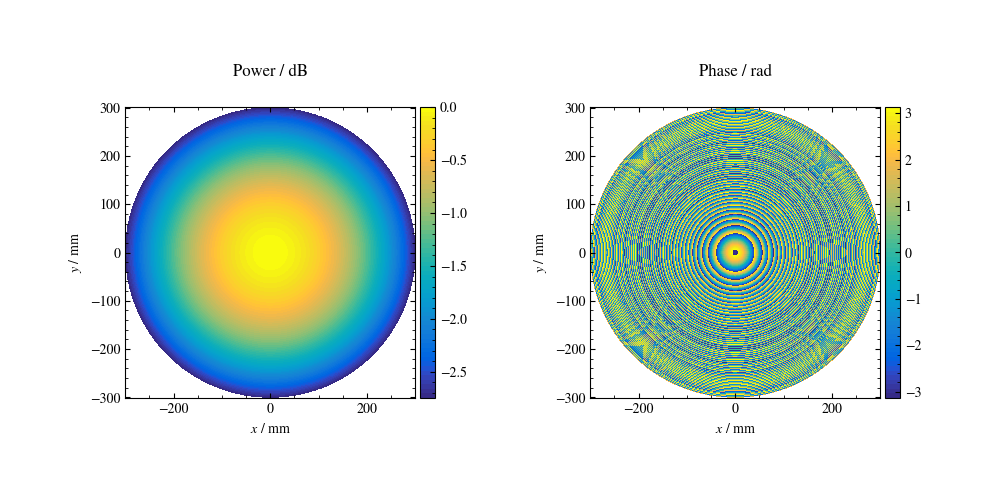

In [56]:
s.plotBeam2D("EH_sec", FieldComponents.Ex)

In [8]:

pri_to_ff = {
        "t_name"    : "farfield",
        "s_current" : "JM_pri",
        "mode"      : "FF",
        "name_EH"   : "EH_ff",
        "device"    : device
        }

s.runPO(pri_to_ff)

2026-02-27 16:20:38 - WORK - *** Starting PO propagation *** 
2026-02-27 16:20:38 - WORK - Propagating JM_pri on primary to farfield, propagation mode: FF. 
2026-02-27 16:20:38 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-27 16:20:38 - WORK - ... Calculating ... 
2026-02-27 16:20:41 - WORK - *** Finished: 3.280 seconds *** 


For visualisation, let's plot the far-field copolar and crosspolar patterns. Note how we specify the axes to be in units of arcseconds, by passing the `units=Units.AS` keyword argument.

Units.AS
as


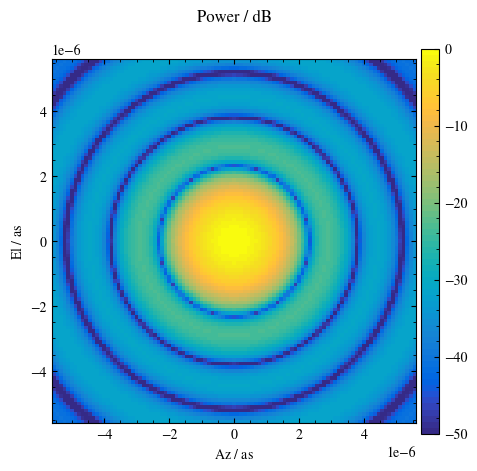

Units.AS
as


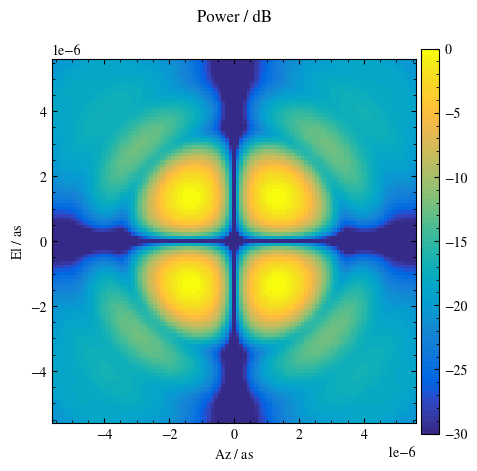

In [9]:
s.plotBeam2D("EH_ff", FieldComponents.Ex, vmin=-50, amp_only=True, units=Units.AS)
s.plotBeam2D("EH_ff", FieldComponents.Ey, vmin=-30, amp_only=True, units=Units.AS)

Now that we have obtained currents on all reflectors and the far-field, we can proceed with the efficiencies calculation. We start by calculating the spillover efficiency on the secondary mirror. For that, we define a plane at the rim height of the secondary. We find the rim height by generating the reflectorgrids and using numpy to find the maximum z co-ordinate. The plane we define is oversized with respect to the secondary radius. This is done in order to capture as much illumination as possible on the plane.

2026-02-27 16:20:45 - INFO - Added plane rim_sec to system. 
2026-02-27 16:20:45 - INFO - Translated element rim_sec by ('0.000e+00', '0.000e+00', '3.398e+03') millimeters. 
2026-02-27 16:20:45 - WORK - *** Starting PO propagation *** 
2026-02-27 16:20:45 - WORK - Propagating source on focus to rim_sec, propagation mode: EH. 
2026-02-27 16:20:45 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-27 16:20:45 - WORK - ... Calculating ... 
2026-02-27 16:20:45 - WORK - *** Finished: 0.686 seconds *** 


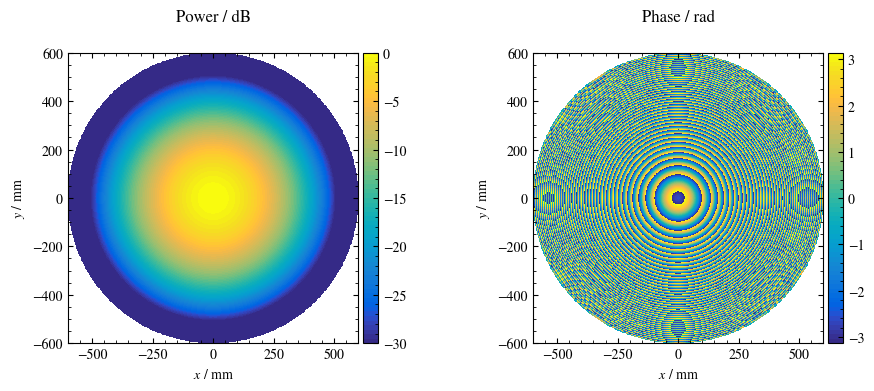

In [10]:
grids_sec = s.generateGrids("secondary")

h_rim = np.max(grids_sec.z)

rim_hyperbola = {
            "name"      : "rim_sec",
            "gmode"     : "uv",
            "flip"      : True,
            "lims_u"    : np.array([0, 300])*Units.MM * 2,
            "lims_v"    : np.array([0, 360])*Units.DEG,
            "gridsize"  : np.array([1501, 500])
            }

s.addPlane(rim_hyperbola)
s.translateGrids("rim_sec", np.array([0, 0, h_rim])*Units.MM)

source_to_rim_sec = {
        "t_name"    : "rim_sec",
        "s_current" : "source",
        "mode"      : "EH",
        "name_EH"   : "EH_rim_sec"
        }

s.runPO(source_to_rim_sec)

aper_sec = {
        "plot"      : True,
        "center"    : np.zeros(2),
        "outer"     : np.array([300, 300])*Units.MM,
        "inner"     : np.zeros(2)
}

s.plotBeam2D("EH_rim_sec", FieldComponents.Ex, vmin=-30)

The spillover efficiency is calculated by defining an aperture (called "aper_sec" here) on which to calculate spillover losses. The aperture is again a dictionary containing several fields. For an explanation, please have a look in the `Templates.py` file, which can also be found in the documentation.

In [11]:
eta_s = s.calcSpillover("EH_rim_sec", FieldComponents.Ex, aper_sec)

The taper efficiency is calculated in the primary aperture. For this we define a plane in the focus of the primary, with the same radius as the primary mirror itself. Because the reflector is large compared to our wavelength, it is infeasible to calculate the aperture field directly using PO. Instead, we adopt a hybrid method where we assume the secondary is sufficiently far from the primary that we can use ray-tracing to calculate the pathlength of a ray of light between the secondary and primary. Also, because the rays coming from the secondary appear to emanate from the prime focus, we need to take into account a spherical spreading factor. Knowing the attenuation factor and the pathlength for a ray, we can calculate the field at the end of the ray by multiplying the reflected field from the secondary by a complex exponential taking into account the travelled distance and by a factor taking into account the spherical spreading.

Fortunately, this is quite easy in `PyPO`. We start by defining a new version of the secondary. For this, we use the `s.copyElement()` method of system to create a copy. Then, we increase the gridsize quite alot so that we have a good ray coverage over the secondary. We then do a regular PO propagation from the source onto the secondary. This time, we set "mode" to "EHP". This returns the reflected electromagnetic fields and the corresponding Poynting vectors `PyPO` automatically converts the reflected Poynting vectors into a frame object. 

We then pass the Poynting vectors, reflected field, target name and output names into a dictionary named hybridDict. Also, we pass "start" as a numpy array of length 3. This parameters sets the origin of our rays coming from the secondary in the primary focus, and is important for calculating the spherical spreading factor which is present when propagating from the secondary to the primary. We set "interp" to False, as we do not need to interpolate the propagated field yet.

The second hybrid propagation has a similar input structure, propagating the hybrid field calculated on the primary to the aperture in the focus. However, we now do not need to set "start" now, because the rays are more or less collimated and do not emanate from a focus. We also pass "comp" as "Ex". Because we interpolate the resulting field on the target surface, we pass the component we want to interpolate. If we do not pass "comp" and leave "interp" to default, PyPO will interpolate all E and H components and this takes considerably longer.

In [12]:
s.copyElement("secondary", "secondary_over")
s.system["secondary_over"]["gridsize"] = np.array([2501, 2500])

foc_pri = {
            "name"      : "foc_pri",
            "gmode"     : "uv",
            "lims_u"    : np.array([300, 5e3])*Units.MM,
            "lims_v"    : np.array([0, 360])*Units.DEG,
            "gridsize"  : np.array([1501, 1500])
            }

s.addPlane(foc_pri)
s.translateGrids("foc_pri", np.array([0, 0, 3.5e3])*Units.MM)

source_to_sec_over = {
        "t_name"    : "secondary_over",
        "s_current" : "source",
        "mode"      : "EHP",
        "name_EH"   : "EH_ref_sec",
        "name_P"    : "P_sec"
        }

s.runPO(source_to_sec_over)

hybrid_1 = {
        "fr_in"     : "P_sec",
        "field_in"  : "EH_ref_sec",
        "t_name"    : "primary",
        "fr_out"    : "primary_frame",
        "field_out" : "primary_hfield",
        "start"     : np.array([0, 0, 3.5e3])*Units.MM,
        "interp"    : False
}

hybrid_2 = {
        "fr_in"     : "primary_frame",
        "field_in"  : "primary_hfield",
        "t_name"    : "foc_pri",
        "fr_out"    : "foc_pri_frame",
        "field_out" : "foc_pri_hfield",
        "comp"      : FieldComponents.Ex
}
s.runHybridPropagation(hybrid_1)
s.runHybridPropagation(hybrid_2)

2026-02-27 14:31:38 - INFO - Copied element secondary to secondary_over. 
2026-02-27 14:31:38 - INFO - Added plane foc_pri to system. 
2026-02-27 14:31:38 - INFO - Translated element foc_pri by ('0.000e+00', '0.000e+00', '3.500e+03') millimeters. 
2026-02-27 14:31:38 - WORK - *** Starting PO propagation *** 
2026-02-27 14:31:38 - WORK - Propagating source on focus to secondary_over, propagation mode: EHP. 
2026-02-27 14:31:38 - WORK - Hardware: running 256 CUDA threads per block. 
2026-02-27 14:31:38 - WORK - ... Calculating ... 
2026-02-27 14:31:46 - WORK - *** Finished: 5.841 seconds *** 
2026-02-27 14:31:46 - WORK - *** Starting hybrid propagation *** 
2026-02-27 14:31:56 - WORK - *** Finished: 9.509 seconds *** 
2026-02-27 14:31:56 - WORK - *** Starting hybrid propagation *** 
2026-02-27 14:32:13 - WORK - *** Finished: 16.721 seconds *** 


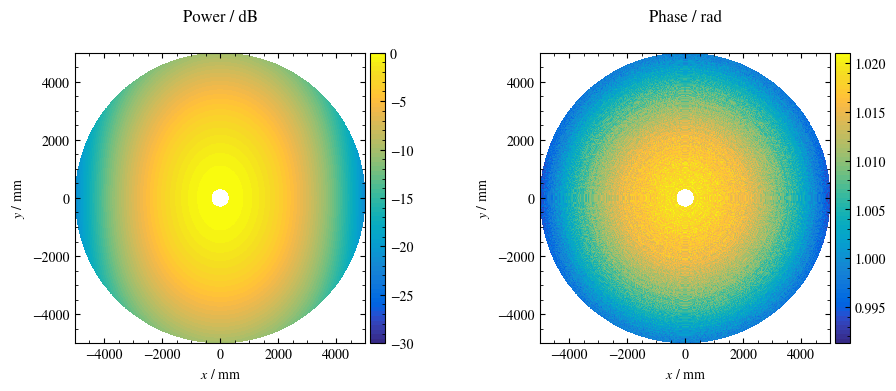

In [13]:
s.plotBeam2D("foc_pri_hfield", FieldComponents.Ex, vmin=-30, norm=False)

In [14]:
eta_t = s.calcTaper("foc_pri_hfield", FieldComponents.Ex)

Now that we have the secondary spillover and taper efficiencies calculated, we can quickly calculate the cross-polarization efficiency induced by the Cassegrain setup, and use these three efficiencies to calculate the total aperture efficiency of this setup, which is just the product of the three efficiencies. Usually, the cross-polar efficiency is close to unity, but we calculate anyways, to demonstrate.

In [15]:
eta_X = s.calcXpol("EH_ff", FieldComponents.Ex, FieldComponents.Ey)

We can also calculate some more parameters. For example, we could calculate the main beam efficiency. This is a metric quantifying the amount of power in the main lobe with respect to the entire beam pattern. Another metric we can calculate is the half-power beamwidth (or more generally, for ellipsoidal beam patterns, the half-power beamwidths), HPBW for short. These represent the widths of the beam in both cardinal planes (the cross sections where the beam is the fattest and the slimmest). PyPO calculates these in degrees as these are the units of the plane on which we calculate the HPBW. We also calculate diffraction-limited HPBW, to compare.

We can also calculate the taper efficiency from the main beam efficiency and HPBWs:
$$ \eta_\mathrm{t} = \frac{\lambda^2}{A} \frac{\eta_\mathrm{mb}}{\Omega_\mathrm{mb}}, $$
where $\lambda$ is the wavelength of light, $A$ the area of the aperture, $\eta_\mathrm{mb}$ the main beam efficiency and $\Omega_\mathrm{mb}$ the main beam solid angle, defined as:
$$ \Omega_\mathrm{mb} = \frac{\pi \theta_\mathrm{E} \theta_\mathrm{H}}{4 \ln 2}, $$
where $\theta$ is the HPBW in the E or H-plane, in radians.

In order to obtain the total aperture efficiency from this taper efficiency, we just multiply by the spillover efficiency and cross-polar efficiency

In [16]:
eta_mb = s.calcMainBeam("EH_ff", FieldComponents.Ex)
Ebw, Hbw = s.calcHPBW("EH_ff", FieldComponents.Ex)
print(Ebw*3600)
diff_lim = lam / (10e3*Units.MM) * 180 / np.pi * 3600
print(diff_lim) 

Omega = np.pi * (np.pi / (180))**2 * Ebw * Hbw / (4 * np.log(2))
eta_ap = lam**2 / (np.pi * (5e3)**2) * eta_mb / Omega * eta_s * eta_X

23.616
20.62648062470964


As an overview, we now print all results from our calculations:

In [17]:
print("*** RESULTS ***")
print(f"Spillover efficiency on secondary: {eta_s:.3f}")
print(f"Taper efficiency in primary aperture: {eta_t:.3f}")
print(f"Cross polar efficiency: {eta_X:.6f}")
print("")
print(f"Main beam efficiency: {eta_mb:.3f}")
print(f"HPBW in E-plane: {Ebw*3600:.3f} as")
print(f"HPBW in H-plane: {Hbw*3600:.3f} as")
print(f"Diffraction-limited HPBW: {diff_lim:.3f} as")
print("")
print(f"Total aperture efficiency from propagation: {eta_X * eta_s * eta_t:.3f}")
print(f"Total aperture efficiency from Main beam efficiency: {eta_ap:.3f}")

*** RESULTS ***
Spillover efficiency on secondary: 0.904
Taper efficiency in primary aperture: 0.807
Cross polar efficiency: 1.000000

Main beam efficiency: 0.974
HPBW in E-plane: 23.616 as
HPBW in H-plane: 23.616 as
Diffraction-limited HPBW: 20.626 as

Total aperture efficiency from propagation: 0.729
Total aperture efficiency from Main beam efficiency: 0.754


We can see that there is a slight discrepancy between the aperture efficiency calculated by forward propagation and by using the far-field pattern. This is because of the different methods involved. Finally, we can plot the cross-sections through the cardinal planes to really see the sidelobes of our far-field pattern:

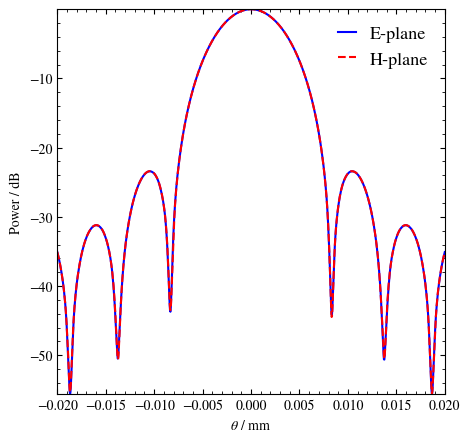

In [18]:
s.plotBeamCut("EH_ff", FieldComponents.Ex)

As expected, the cross sections are very symmetric and show the characteristic sidelobes for circularly symmetric reflectors. As an exercise to the reader, can you make a setup for calculating, for example, the spillover losses on the primary reflector? Or maybe see what the effect is of slightly tilting the Gaussian source on the aperture efficiency?